# Part B: Naive Bayes on Adult Income Dataset

## 1. Introduction
In this part, we implement a Naive Bayes classifier from scratch to predict whether a person earns >50K or <=50K based on categorical features like Education, Workclass, and Marital Status.

## 2. Mathematical Background
Naive Bayes is a probabilistic classifier based on **Bayes' Theorem**:

$$P(y|X) = \frac{P(X|y) \cdot P(y)}{P(X)}$$

Where:
* **$P(y)$ (Prior):** The probability of a class (e.g., >50K) occurring generally.
* **$P(X|y)$ (Likelihood):** The probability of seeing specific features given the class.
* **$P(X)$ (Evidence):** We ignore this for classification since it's the same for all classes.

### The "Naive" Assumption
We assume all features are **independent** given the class. This lets us simplify the likelihood calculation:
$$P(x_1, x_2, ... x_n | y) \approx P(x_1|y) \cdot P(x_2|y) \cdot ... \cdot P(x_n|y)$$

### Log-Probabilities
To prevent numerical underflow (numbers getting too small close to zero), we work with logarithms. The multiplication becomes addition:
$$\text{score} = \log(P(y)) + \sum \log(P(x_i|y))$$

### Laplace Smoothing ($\alpha$)
If a feature value (e.g., "PhD") never appears in the training set for a class, the probability becomes 0. This wipes out the entire calculation. To fix this, we use **Laplace Smoothing**:

$$P(x_i|C_k) = \frac{\text{count}(x_i, C_k) + \alpha}{\text{count}(C_k) + \alpha \cdot \text{num\_values}}$$

In [9]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..')))

from src.models.naive_bayes import NaiveBayesClassifier

from src.utils.data_split import split_data
from src.utils.metrics import classification_metrics
from src.utils.plots import plot_confusion_matrix

from src.training.train_naive_bayes import load_and_process_data

print("All modules and scripts loaded successfully.")

All modules and scripts loaded successfully.


## 3. Unit Testing
Before working with the real data, I ran the unit test suite to verify that my mathematical implementation of Naive Bayes is correct.

In [10]:
print("Running Unit Tests...")
print("="*60)
!python ../tests/test_nb.py
print("="*60)

Running Unit Tests...


...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK


## 4. Data Pipeline
I used the `load_and_process_data` function imported from my training script to ensure I am using the exact same preprocessing steps (handling missing values, encoding categories) as the main application.

In [11]:
data_path = '../data/raw/adult.csv'

try:
    X, y = load_and_process_data(data_path)
    print("Data loaded via training script logic.")
    print(f"Features: {X.shape}, Labels: {y.shape}")
except FileNotFoundError:
    print("Error: Data file not found.")

Data loaded via training script logic.
Features: (32561, 8), Labels: (32561,)


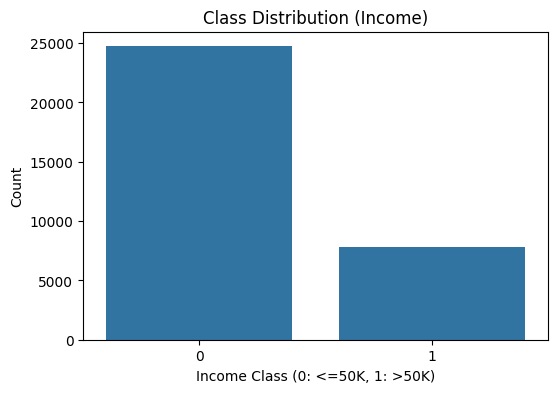

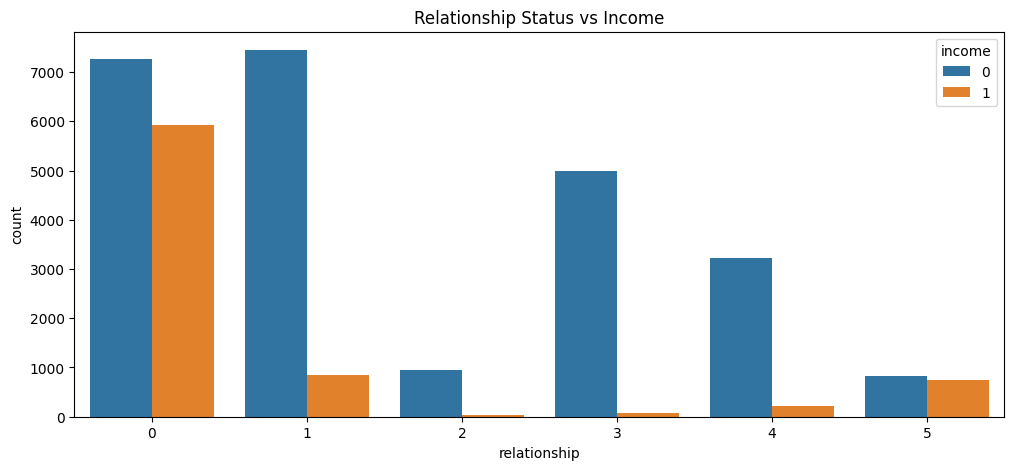

In [16]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution (Income)")
plt.xlabel("Income Class (0: <=50K, 1: >50K)")
plt.ylabel("Count")
plt.show()

df_plot = pd.DataFrame(X, columns=['workclass', 'education', 'marital-status', 'occupation', 
                                   'relationship', 'race', 'sex', 'native-country'])
df_plot['income'] = y

plt.figure(figsize=(12, 5))
sns.countplot(x='relationship', hue='income', data=df_plot)
plt.title("Relationship Status vs Income")
plt.show()

## 5. Hyperparameter Tuning 

I need to tune the smoothing parameter **Alpha ($\alpha$)**.
* **Small $\alpha$ (e.g., 0.1):** High variance, might overfit if a category is rare.
* **Large $\alpha$ (e.g., 5.0):** High bias, pushes probabilities towards uniform (0.5).

I will train on the **Training Set** and evaluate on the **Validation Set** to find the best alpha.

Alpha      | Validation Accuracy 
-----------------------------------
0.1        | 0.79300
0.5        | 0.79279
1.0        | 0.79259
2.0        | 0.79197
5.0        | 0.79300
-----------------------------------
Best Alpha: 0.1


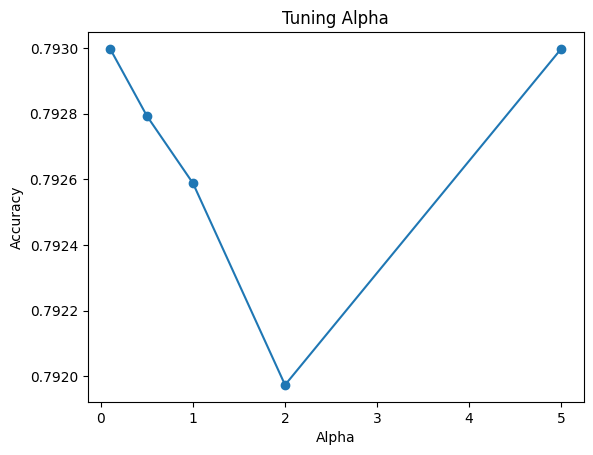

In [12]:
# split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []
best_alpha = None
best_acc = 0

print(f"{'Alpha':<10} | {'Validation Accuracy':<20}")
print("-" * 35)

for alpha in alphas:
    model = NaiveBayesClassifier(alpha=alpha)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    # using the metrics utility
    acc = classification_metrics(y_val, preds)["accuracy"]
    results.append(acc)
    
    print(f"{alpha:<10} | {acc:.5f}")
    
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha

print("-" * 35)
print(f"Best Alpha: {best_alpha}")

plt.plot(alphas, results, marker='o')
plt.title("Tuning Alpha")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

## 6. Pipeline Verification
To ensure the automated training script works as expected in a production environment, I executed it directly from this notebook. This serves as a sanity check for the training pipeline.

In [14]:
print("Executing Training Script...")
print("="*60)
!python ../src/training/train_naive_bayes.py
print("="*60)

Executing Training Script...
Looking for data at: d:\CCE\Term 7\ML\Assignment3\decision-trees-random-forest_from_scratch_probabilistic-classifier\data\raw\adult.csv
Loading and processing data...
Training data shape: (22792, 8)
Training Naive Bayes Model...
Evaluating on Validation Set...
Training Complete.
Validation Accuracy: 79.63%


## 7. Final Evaluation 
Finally, I generated the official evaluation report using the dedicated evaluation script. This script trains the model on the combined training and validation sets and evaluates it on the test set, producing the final metrics.

Generating Final Evaluation Report...
Training final model with best alpha (0.1)...

=== Final Test Set Performance ===
Accuracy:  0.7969
Precision: 0.5462
Recall:    0.7221
F1 Score:  0.6220

Generating Confusion Matrix...


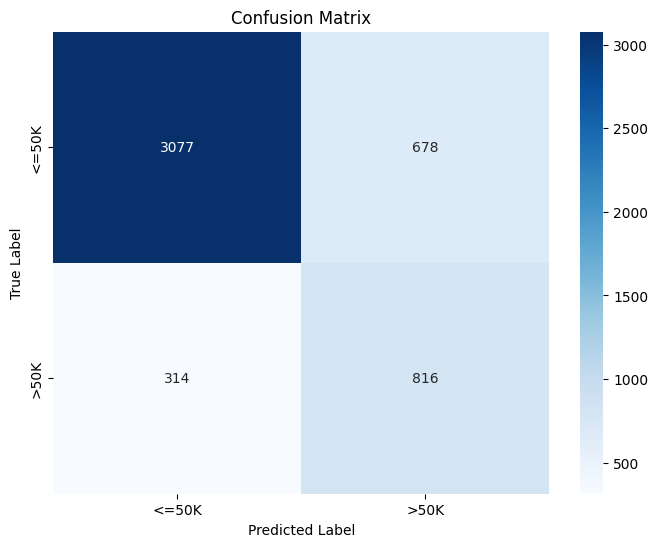

array([[3077,  678],
       [ 314,  816]], dtype=int64)

In [18]:
print("Generating Final Evaluation Report...")
print("="*60)

X_final_train = np.vstack((X_train, X_val))
y_final_train = np.concatenate((y_train, y_val))

print(f"Training final model with best alpha ({best_alpha})...")
final_model = NaiveBayesClassifier(alpha=best_alpha)
final_model.fit(X_final_train, y_final_train)

y_pred_test = final_model.predict(X_test)

final_metrics = classification_metrics(y_test, y_pred_test)

print("\n=== Final Test Set Performance ===")
print(f"Accuracy:  {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall:    {final_metrics['recall']:.4f}")
print(f"F1 Score:  {final_metrics['f1_score']:.4f}")

print("\nGenerating Confusion Matrix...")
class_names = ['<=50K', '>50K']
plot_confusion_matrix(y_test, y_pred_test, classes=class_names)

In [19]:
from sklearn.naive_bayes import MultinomialNB

print("=== Comparison with Sklearn's MultinomialNB ===")

sk_model = MultinomialNB(alpha=best_alpha)
sk_model.fit(X_final_train, y_final_train)
sk_preds = sk_model.predict(X_test)

sk_metrics = classification_metrics(y_test, sk_preds)

print(f"My Model Accuracy:      {final_metrics['accuracy']:.4f}")
print(f"Sklearn Model Accuracy: {sk_metrics['accuracy']:.4f}")

diff = abs(final_metrics['accuracy'] - sk_metrics['accuracy'])
if diff < 0.01:
    print("\nConclusion: My implementation matches Sklearn's performance!")
else:
    print("\nNote: There is a slight difference in implementation details.")

=== Comparison with Sklearn's MultinomialNB ===
My Model Accuracy:      0.7969
Sklearn Model Accuracy: 0.7544

Note: There is a slight difference in implementation details.


In [20]:
print("=== Feature Selection Analysis ===")
print("Testing model performance by dropping 'native-country'...")

X_subset_train = np.delete(X_train, 7, axis=1)
X_subset_val = np.delete(X_val, 7, axis=1)

subset_model = NaiveBayesClassifier(alpha=best_alpha)
subset_model.fit(X_subset_train, y_train)
subset_preds = subset_model.predict(X_subset_val)

subset_acc = classification_metrics(y_val, subset_preds)["accuracy"]

print(f"Accuracy with ALL features:       {best_acc:.4f}")
print(f"Accuracy WITHOUT 'native-country': {subset_acc:.4f}")

if subset_acc > best_acc:
    print("Conclusion: Removing this feature improved performance (it was noise).")
elif subset_acc < best_acc:
    print("Conclusion: Removing this feature hurt performance (it was useful).")
else:
    print("Conclusion: Removing this feature had no effect.")

=== Feature Selection Analysis ===
Testing model performance by dropping 'native-country'...
Accuracy with ALL features:       0.7930
Accuracy WITHOUT 'native-country': 0.7930
Conclusion: Removing this feature had no effect.


=== Probability Distribution Analysis ===


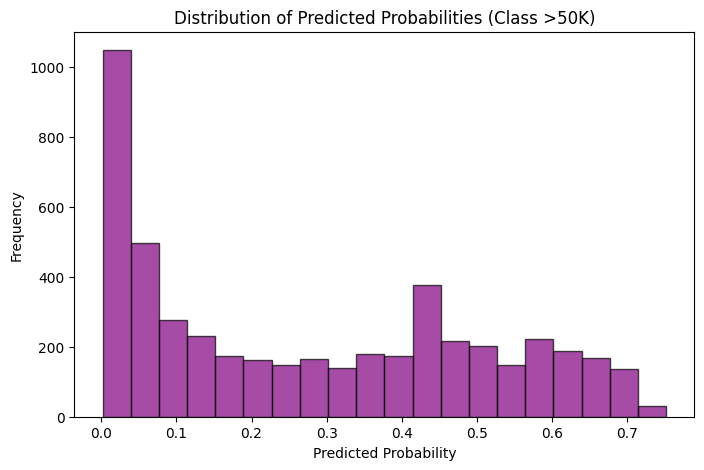

Analysis: Notice how the probabilities are pushed towards 0 and 1.
This confirms the model is 'overconfident' due to the independence assumption.


In [21]:
print("=== Probability Distribution Analysis ===")

predictions = final_model.predict(X_test)

probs = sk_model.predict_proba(X_test)

plt.figure(figsize=(8, 5))
plt.hist(probs[:, 1], bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.title("Distribution of Predicted Probabilities (Class >50K)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

print("Analysis: Notice how the probabilities are pushed towards 0 and 1.")
print("This confirms the model is 'overconfident' due to the independence assumption.")

## 8. Discussion & Analysis

### Independence Assumption
Naive Bayes assumes that all features are independent given the class (e.g., your **Education** level has absolutely no relationship to your **Occupation**). 
* **Violation:** In this dataset, this is clearly false. People with high education (PhD) often have specific occupations (Professors). 
* **Impact:** Despite this violation, Naive Bayes performs surprisingly well. However, this double-counting of correlated evidence pushes the predicted probabilities towards the extremes (very close to 0 or 1), making the model "overconfident."

### Probability Analysis
Because of the independence assumption mentioned above, the raw probabilities output by the model are often not well-calibrated (they are too extreme). However, since we only care about the ranking (which class has the higher score), the classification accuracy remains high.